# **BREAST CANCER SURVIVAL STATUS PREDICTION NOTEBOOK**

## **Summary**

1. Importing libraries and data
2. Data cleaning and preparation
3. Data transformation function
4. Training: first models
5. Training: hyperparameters tuning
6. Model finalization
7. Test on unseen data

.

.

## **1. Importing libraries and data**

In [1]:
#Importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import skew
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing data
Data = pd.read_csv("analitics_hub_tcga_output.csv")
Data

,Patient ID,Definition,Tumour Stage,Survival Status,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype
0,TCGA-3C-AAAU,primary solid tumor,X,alive,female,premenopausal,white,55.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,LumA
1,TCGA-3C-AALI,primary solid tumor,2b,alive,female,postmenopausal,black or african american,50.0,positive,positive,positive,NaN,NaN,infiltrating ductal carcinoma,Basal
2,TCGA-3C-AALJ,primary solid tumor,2b,alive,female,postmenopausal,black or african american,NaN,positive,positive,indeterminate,NaN,NaN,infiltrating ductal carcinoma,Basal
3,TCGA-3C-AALK,primary solid tumor,1a,alive,female,unknown,black or african american,NaN,positive,positive,positive,NaN,NaN,infiltrating ductal carcinoma,LumA
4,TCGA-4H-AAAK,primary solid tumor,3a,alive,female,postmenopausal,white,50.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,Her2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,TCGA-WT-AB44,primary solid tumor,1a,alive,female,postmenopausal,white,77.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,Basal
1201,TCGA-XX-A899,primary solid tumor,3a,alive,female,postmenopausal,white,46.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,LumA
1202,TCGA-XX-A89A,primary solid tumor,2b,alive,female,postmenopausal,white,68.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,LumB
1203,TCGA-Z7-A8R5,primary solid tumor,3a,alive,female,postmenopausal,white,61.0,positive,positive,negative,NaN,NaN,infiltrating lobular carcinoma,LumA


In [3]:
#Data information
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient ID         1205 non-null   object 
 1   Definition         1205 non-null   object 
 2   Tumour Stage       1193 non-null   object 
 3   Survival Status    1205 non-null   object 
 4   Gender             1205 non-null   object 
 5   Menopausal Status  1203 non-null   object 
 6   Race               1205 non-null   object 
 7   Age                1200 non-null   float64
 8   ER                 1092 non-null   object 
 9   PR                 1092 non-null   object 
 10  HER2               1086 non-null   object 
 11  Lymph Node         776 non-null    object 
 12  Metastasis         771 non-null    object 
 13  Histological Type  1203 non-null   object 
 14  Subtype            1093 non-null   object 
dtypes: float64(1), object(14)
memory usage: 141.3+ KB


.

Almost all features are "object" (i.e. categorical features)

Feature description:
- Patiet ID (it is a code dividied in three parts, containing information about the patient and the tumour study)
- Definition (definition of the tumour)
- Tumour stage (there are three stages - 1,2,3 -, divided in two parts - a,b - describing the tumour phase)
- Survival Status (target variable: "alive" or "deceased")
- Gender ("male" or "female")
- Menopausal Status (only related to female patients)
- Race (categorization based on shared physical qualities)
- Age (age of the patient)
- ER (Estrogen receptor: "positive" if present, "negative" otherwise)
- PR (Progesterone receptor: "positive" if present, "negative" otherwise)
- HER2 (Human epidermal growth factor receptor 2: "positive" if present, "negative" otherwise)
- Lymph Node (small structures that work as filters: "absent" or "present")
- Metastasis (pathogenic agent's spread from an initial site to a secondary site: "absent" or "present")
- Histological Type (type of cancer)
- Subtype (cancer subtype)

In [4]:
#Missing values
Data.isna().sum()

Patient ID             0
Definition             0
Tumour Stage          12
Survival Status        0
Gender                 0
Menopausal Status      2
Race                   0
Age                    5
ER                   113
PR                   113
HER2                 119
Lymph Node           429
Metastasis           434
Histological Type      2
Subtype              112
dtype: int64

.

There are several features with missing values. For some of those, a common imputation method (i.e. mean/median/mode)
is not appropriate given that each patient has his/her own data. 

Some alternative options are:
- Remove all NaN values (this will reduce the dataset)
- Set those values to 0 (meaning that the measure is absent or unknown)

Let's create a Training and a Test: this latter will be 3% of the original dataset (36 samples) and it will be used
as *unseen data* at the end of this notebook.

In [5]:
#Creation of a Training set and a Test set 
X_train, X_test, y_train, y_test = train_test_split(Data.drop(["Survival Status"],axis=1),
                                                    Data["Survival Status"], 
                                                    test_size = 0.03, random_state = 0)

X_train

,Patient ID,Definition,Tumour Stage,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype
141,TCGA-A7-A13G,primary solid tumor,2a,female,postmenopausal,white,79.0,positive,positive,negative,absent,absent,infiltrating lobular carcinoma,Basal
541,TCGA-BH-A0B4,primary solid tumor,3a,male,not available,white,65.0,positive,positive,equivocal,present,absent,infiltrating ductal carcinoma,LumA
851,TCGA-D8-A1XW,primary solid tumor,2a,female,postmenopausal,white,53.0,negative,positive,negative,absent,absent,infiltrating ductal carcinoma,LumA
487,TCGA-B6-A0IO,primary solid tumor,2a,female,indeterminate,white,66.0,positive,indeterminate,not evaluated,absent,absent,infiltrating ductal carcinoma,LumA
412,TCGA-AR-A0TZ,primary solid tumor,NaN,female,premenopausal,white,43.0,positive,positive,equivocal,present,absent,infiltrating ductal carcinoma,Basal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,TCGA-E9-A22G,primary solid tumor,2a,female,postmenopausal,white,47.0,negative,negative,positive,absent,absent,infiltrating ductal carcinoma,LumA
763,TCGA-C8-A12X,primary solid tumor,2b,female,postmenopausal,asian,62.0,positive,positive,negative,present,absent,mucinous carcinoma,LumB
835,TCGA-D8-A1XB,primary solid tumor,2b,female,postmenopausal,white,62.0,positive,positive,negative,present,absent,infiltrating ductal carcinoma,LumA
559,TCGA-BH-A0BL,primary solid tumor,1,female,premenopausal,white,35.0,negative,negative,negative,absent,absent,infiltrating ductal carcinoma,LumA


.

.

## **2. Data cleaning and preparation**

In [6]:
#Training data information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 141 to 684
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient ID         1168 non-null   object 
 1   Definition         1168 non-null   object 
 2   Tumour Stage       1156 non-null   object 
 3   Gender             1168 non-null   object 
 4   Menopausal Status  1166 non-null   object 
 5   Race               1168 non-null   object 
 6   Age                1164 non-null   float64
 7   ER                 1059 non-null   object 
 8   PR                 1059 non-null   object 
 9   HER2               1054 non-null   object 
 10  Lymph Node         751 non-null    object 
 11  Metastasis         747 non-null    object 
 12  Histological Type  1166 non-null   object 
 13  Subtype            1060 non-null   object 
dtypes: float64(1), object(13)
memory usage: 136.9+ KB


.

For what concerns the "Patient_ID" column, each code name is made of three parts:
- The first part is the acronym for "The Cancer Genome Atlas" (TCGA)
- The second one refers to a particular type of cancer 
- The third one is a code related to the patient

There are 830 different types of cancer (from https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tissue-source-site-codes)

In [7]:
#Creation of a series with the 830 different types of cancer.
TSS = ["1","2","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","1Z","20","21","22","23","24","25",
       "26","27","28","29","2A","2E","2F","2G","2H","2J","2K","2L","2M","2N","2P","2V","2W","2X","2Y","2Z","30","31","32","33",
       "34","35","36","37","38","39","3A","3B","3C","3E","3G","3H","3J","3K","3L","3M","3N","3P","3Q","3R","3S","3T","3U","3W",
       "3X","3Z","41","42","43","44","46","49","4A","4B","4C","4D","4E","4G","4H","4J","4K","4L","4N","4P","4Q","4R","4S","4T",
       "4V","4W","4X","4Y","4Z","50","51","52","53","55","56","57","58","59","5A","5B","5C","5D","5F","5G","5H","5J","5K","5L",
       "5M","5N","5P","5Q","5R","5S","5T","5U","5V","5W","5X","60","61","62","63","64","65","66","67","68","69","6A","6D","6G",
       "6H","70","71","72","73","74","75","76","77","78","79","80","81","82","83","85","86","87","90","91","92","93","94","95",
       "96","97","98","99","A1","A2","A3","A4","A5","A6","A7","A8","AA","AB","AC","AD","AF","AG","AH","AJ","AK","AL","AM","AN",
       "AO","AP","AQ","AR","AS","AT","AU","AV","AW","AX","AY","AZ","B0","B1","B2","B3","B4","B5","B6","B7","B8","B9","BA","BB",
       "BC","BD","BF","BG","BH","BI","BJ","BK","BL","BM","BP","BQ","BR","BS","BT","BW","C4","C5","C8","C9","CA","CB","CC","CD",
       "CE","CF","CG","CH","CI","CJ","CK","CL","CM","CN","CQ","CR","CS","CU","CV","CW","CX","CZ","D1","D3","D5","D6","D7","D8",
       "D9","DA","DB","DC","DD","DE","DF","DG","DH","DI","DJ","DK","DM","DO","DQ","DR","DS","DT","DU","DV","DW","DX","DY","DZ",
       "E1","E2","E3","E5","E6","E7","E8","E9","EA","EB","EC","ED","EE","EF","EI","EJ","EK","EL","EM","EO","EP","EQ","ER","ES",
       "ET","EU","EV","EW","EX","EY","EZ","F1","F2","F4","F5","F6","F7","F9","FA","FB","FC","FD","FE","FF","FG","FH","FI","FJ",
       "FK","FL","FM","FN","FP","FQ","FR","FS","FT","FU","FV","FW","FX","FY","FZ","G2","G3","G4","G5","G6","G7","G8","G9","GC",
       "GD","GE","GF","GG","GH","GI","GJ","GK","GL","GM","GN","GP","GR","GS","GU","GV","GZ","H1","H2","H3","H4","H5","H6","H7",
       "H8","H9","HA","HB","HC","HD","HE","HF","HG","HH","HI","HJ","HK","HL","HM","HN","HP","HQ","HR","HS","HT","HU","HV","HW",
       "HZ","IA","IB","IC","IE","IF","IG","IH","IJ","IK","IM","IN","IP","IQ","IR","IS","IW","IZ","J1","J2","J4","J7","J8","J9",
       "JA","JL","JU","JV","JW","JX","JY","JZ","K1","K4","K6","K7","K8","KA","KB","KC","KD","KE","KF","KG","KH","KJ","KK","KL",
       "KM","KN","KO","KP","KQ","KR","KS","KT","KU","KV","KZ","L1","L3","L4","L5","L6","L7","L8","L9","LA","LB","LC","LD","LG",
       "LH","LI","LK","LL","LN","LP","LQ","LS","LT","M7","M8","M9","MA","MB","ME","MF","MG","MH","MI","MJ","MK","ML","MM","MN",
       "MO","MP","MQ","MR","MS","MT","MU","MV","MW","MX","MY","MZ","N1","N5","N6","N7","N8","N9","NA","NB","NC","ND","NF","NG",
       "NH","NI","NJ","NK","NM","NP","NQ","NS","O1","O2","O8","O9","OC","OD","OE","OJ","OK","OL","OR","OU","OW","OX","OY","P3",
       "P4","P5","P6","P7","P8","P9","PA","PB","PC","PD","PE","PG","PH","PJ","PK","PL","PN","PQ","PR","PT","PZ","Q1","Q2","Q3",
       "Q4","Q9","QA","QB","QC","QD","QF","QG","QH","QJ","QK","QL","QM","QN","QQ","QR","QS","QT","QU","QV","QW","R1","R2","R3",
       "R5","R6","R7","R8","R9","RA","RB","RC","RD","RE","RG","RH","RL","RM","RN","RP","RQ","RR","RS","RT","RU","RV","RW","RX",
       "RY","RZ","S2","S3","S4","S5","S6","S7","S8","S9","SA","SB","SC","SD","SE","SG","SH","SI","SJ","SK","SL","SN","SO","SP",
       "SQ","SR","SS","ST","SU","SW","SX","SY","T1","T2","T3","T6","T7","T9","TE","TG","TK","TL","TM","TN","TP","TQ","TR","TS",
       "TT","TV","UB","UC","UD","UE","UF","UJ","UL","UN","UP","UR","US","UT","UU","UV","UW","UY","UZ","V1","V2","V3","V4","V5",
       "V6","V7","V8","V9","VA","VB","VD","VF","VG","VK","VL","VM","VN","VP","VQ","VR","VS","VT","VV","VW","VX","VZ","W2","W3",
       "W4","W5","W6","W7","W8","W9","WA","WB","WC","WD","WE","WF","WG","WH","WJ","WK","WL","WM","WN","WP","WQ","WR","WS","WT",
       "WU","WW","WX","WY","WZ","X2","X3","X4","X5","X6","X7","X8","X9","XA","XB","XC","XD","XE","XF","XG","XH","XJ","XK","XM",
       "XN","XP","XQ","XR","XS","XT","XU","XV","XX","XY","Y3","Y5","Y6","Y8","YA","YB","YC","YD","YF","YG","YH","YJ","YL","YN",
       "YR","YS","YT","YU","YV","YW","YX","YY","YZ","Z2","Z3","Z4","Z5","Z6","Z7","Z8","ZA","ZB","ZC","ZD","ZE","ZF","ZG","ZH",
       "ZJ","ZK","ZL","ZM","ZN","ZP","ZQ","ZR","ZS","ZT","ZU","ZW","ZX"]

In [8]:
#Recover the TSS code from the patient ID and store it into the new column "Tumour_info"
X_train["Tumour_info"] = X_train["Patient ID"].str.split("-",expand=True).iloc[:,1]
X_train.drop(["Patient ID"],axis=1, inplace=True)
X_train.head()

,Definition,Tumour Stage,Gender,Menopausal Status,Race,Age,ER,PR,HER2,Lymph Node,Metastasis,Histological Type,Subtype,Tumour_info
141,primary solid tumor,2a,female,postmenopausal,white,79.0,positive,positive,negative,absent,absent,infiltrating lobular carcinoma,Basal,A7
541,primary solid tumor,3a,male,not available,white,65.0,positive,positive,equivocal,present,absent,infiltrating ductal carcinoma,LumA,BH
851,primary solid tumor,2a,female,postmenopausal,white,53.0,negative,positive,negative,absent,absent,infiltrating ductal carcinoma,LumA,D8
487,primary solid tumor,2a,female,indeterminate,white,66.0,positive,indeterminate,not evaluated,absent,absent,infiltrating ductal carcinoma,LumA,B6
412,primary solid tumor,NaN,female,premenopausal,white,43.0,positive,positive,equivocal,present,absent,infiltrating ductal carcinoma,Basal,AR


In [9]:
#Unique values in categorical features
for i in ['Definition', 'Tumour Stage', 'Gender', 'Menopausal Status', 'Race','ER', 'PR', 
          'HER2', 'Lymph Node', 'Metastasis', 'Histological Type', 'Subtype', 'Tumour_info'] :
    if X_train[i].dtype == "object" :
        print(i, ": ", X_train[i].unique())

Definition :  ['primary solid tumor' 'solid tissue normal']
Tumour Stage :  ['2a' '3a' nan '1a' '4' '1' '2b' '3c' '3b' 'X' '3' '2' '1b']
Gender :  ['female' 'male']
Menopausal Status :  ['postmenopausal' 'not available' 'indeterminate' 'premenopausal'
 'perimenopausal' 'unknown' 'not evaluated' nan]
Race :  ['white' 'black or african american' 'not reported' 'asian'
 'american indian or alaska native']
ER :  ['positive' 'negative' nan 'not evaluated' 'indeterminate']
PR :  ['positive' 'indeterminate' nan 'negative' 'not evaluated']
HER2 :  ['negative' 'equivocal' 'not evaluated' nan 'positive' 'indeterminate']
Lymph Node :  ['absent' 'present' nan]
Metastasis :  ['absent' nan 'present']
Histological Type :  ['infiltrating lobular carcinoma' 'infiltrating ductal carcinoma' 'other'
 'mixed histology' 'metaplastic carcinoma' 'mucinous carcinoma'
 'medullary carcinoma' nan 'infiltrating carcinoma nos' 'not available']
Subtype :  ['Basal' 'LumA' nan 'Normal' 'LumB' 'Her2']
Tumour_info :  ['

.

For each feature:
- Strings as "not available", "unknown", "not evaluated", "not reported", "indeterminate", will be replaced with 0
- All the other strings will be replaced with numbers larger than 0
- NaN values will be replaced with 0

In [10]:
#Categorical to numerical transformation
X_train["Definition"].replace(['primary solid tumor','solid tissue normal'],[1,2], inplace=True) 
X_train["Gender"].replace(['female','male'],[1,2], inplace=True)
X_train["Menopausal Status"].replace(['postmenopausal','perimenopausal','premenopausal','not available',
                                      'unknown','not evaluated','indeterminate'],[3,2,1,0,0,0,0], inplace=True)
X_train["Race"].replace(['white','american indian or alaska native','black or african american','asian',
                         'not reported'],[1,2,3,4,0], inplace=True)
X_train["ER"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
X_train["PR"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
X_train["HER2"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
X_train["Lymph Node"].replace(['present','absent'],[2,1], inplace=True)
X_train["Metastasis"].replace(['present','absent'],[2,1], inplace=True)
X_train["Histological Type"].replace(['infiltrating carcinoma nos','infiltrating lobular carcinoma','infiltrating ductal carcinoma',
                                      'medullary carcinoma','metaplastic carcinoma','mixed histology','mucinous carcinoma',
                                      'other','not available'],[1,2,3,4,5,6,7,8,0], inplace=True)
X_train["Subtype"].replace(['Basal','Her2','LumA','LumB','Normal'],[1,2,3,4,5], inplace=True)
X_train["Tumour_info"].replace(TSS,np.arange(1,len(TSS)+1), inplace=True)


#Missing values
X_train["Tumour Stage"].fillna("0",inplace=True)             #As string
X_train["Menopausal Status"].fillna(0,inplace=True)
X_train["ER"].fillna(0,inplace=True)
X_train["PR"].fillna(0,inplace=True)
X_train["HER2"].fillna(0,inplace=True)
X_train["Lymph Node"].fillna(0,inplace=True)
X_train["Metastasis"].fillna(0,inplace=True)
X_train["Histological Type"].fillna(0,inplace=True)
X_train["Subtype"].fillna(0,inplace=True)


#Data information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 141 to 684
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Definition         1168 non-null   int64  
 1   Tumour Stage       1168 non-null   object 
 2   Gender             1168 non-null   int64  
 3   Menopausal Status  1168 non-null   float64
 4   Race               1168 non-null   int64  
 5   Age                1164 non-null   float64
 6   ER                 1168 non-null   float64
 7   PR                 1168 non-null   float64
 8   HER2               1168 non-null   float64
 9   Lymph Node         1168 non-null   float64
 10  Metastasis         1168 non-null   float64
 11  Histological Type  1168 non-null   float64
 12  Subtype            1168 non-null   float64
 13  Tumour_info        1168 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 136.9+ KB


.

Some missing values are present in the column "Age"

<AxesSubplot:xlabel='Age', ylabel='Count'>

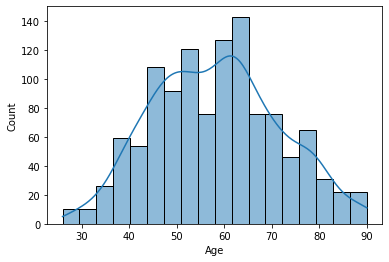

In [11]:
#Histogram of the feature "Age"
sn.histplot(x=X_train.Age, kde=True)

In [12]:
#Mean and Median age
print("The mean is: ", X_train.Age.mean(), "\nThe median is: ",X_train.Age.median())

The mean is:  58.324742268041234 
The median is:  58.0


In [13]:
#Use the median to replace missing "Age" values
X_train_MEDIAN = X_train.Age.median()                #It will be used later
X_train.Age.fillna(X_train_MEDIAN,inplace=True)

#Missing values
print("Number of missing values: ", X_train.isna().sum().sum())

Number of missing values:  0


.

No missing values anymore

Let's deal with "Tumour Stage" feature. The unique values are:
- '3a' '3c' '2a' '1' '2b' '1a' '2' '4' '1b' '3b' 'X' '3'

The following substitutions will be applied:
- Set X = 0 (the X is present when the primary tumor cannot be assessed) 
- Set all the others as 1,2,3
- If a letter is present, it will be replaced with a number (i.e., a=1, b=2, c=3). If absent, 0.

In [14]:
#Split the "Tumour Stage" column (i.e. number + letter)
Num = X_train["Tumour Stage"].str.split("",expand=True)[1]
Sta = X_train["Tumour Stage"].str.split("",expand=True)[2]
Stage = pd.DataFrame(pd.concat([Num,Sta],axis=1))
Stage.columns=["T_Stage1","T_Stage2"]


#Replace letters with numbers (0 if absent)
i=0
while i<len(Stage) :
    if Stage.iloc[i,0] == "X":
        Stage.iloc[i,0] = 0
    if Stage.iloc[i,1] == "a" :
        Stage.iloc[i,1] = 1
    if Stage.iloc[i,1] == "b" :
        Stage.iloc[i,1] = 2
    if Stage.iloc[i,1] == "c" :
        Stage.iloc[i,1] = 3
    if Stage.iloc[i,1]=="" :
        Stage.iloc[i,1] = 0
    i=i+1
    
    
#Insert new columns ("T_Stage1","T_Stage2") in the original datasets and remove "Tumour Stage"
X_train = pd.concat([Stage,X_train],axis=1)
X_train.drop(["Tumour Stage"],axis=1,inplace=True)
X_train


#Convert "T_Stage1" and "T_Stage2" into a numeric format
X_train["T_Stage1"] = pd.to_numeric(X_train["T_Stage1"])
X_train["T_Stage2"] = pd.to_numeric(X_train["T_Stage2"])


#Data information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 141 to 684
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   T_Stage1           1168 non-null   int64  
 1   T_Stage2           1168 non-null   int64  
 2   Definition         1168 non-null   int64  
 3   Gender             1168 non-null   int64  
 4   Menopausal Status  1168 non-null   float64
 5   Race               1168 non-null   int64  
 6   Age                1168 non-null   float64
 7   ER                 1168 non-null   float64
 8   PR                 1168 non-null   float64
 9   HER2               1168 non-null   float64
 10  Lymph Node         1168 non-null   float64
 11  Metastasis         1168 non-null   float64
 12  Histological Type  1168 non-null   float64
 13  Subtype            1168 non-null   float64
 14  Tumour_info        1168 non-null   int64  
dtypes: float64(9), int64(6)
memory usage: 146.0 KB


.

Now the dataset is complete (no missing values) and it has only numeric values (1168 entries in 15 columns)

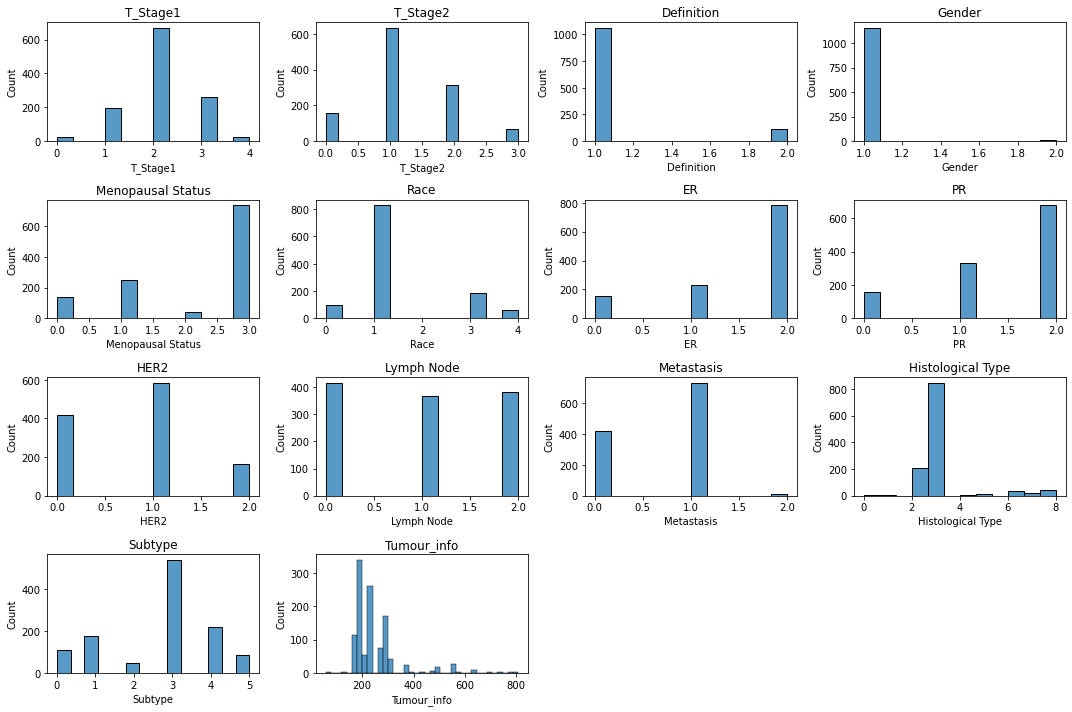

In [15]:
#Data distribution for categorical features
plt.figure(figsize=(15,10))
j=1
for i in ["T_Stage1","T_Stage2","Definition","Gender","Menopausal Status","Race","ER","PR",
          "HER2","Lymph Node","Metastasis","Histological Type","Subtype","Tumour_info"] :
    plt.subplot(4,4,j)
    sn.histplot(x = X_train[i])
    plt.title(i)
    j=j+1

plt.tight_layout()

.

Some features are unbalanced like "Gender"

In [16]:
#Value count for "Gender":
X_train.Gender.value_counts()

1    1155
2      13
Name: Gender, dtype: int64

.

There are only 13 males that may be trated as generic patient along with females: in this way, the column "Gender" can be removed.

To check if that removal can be applied, let's take a look at the values throughout the dataset for males and females

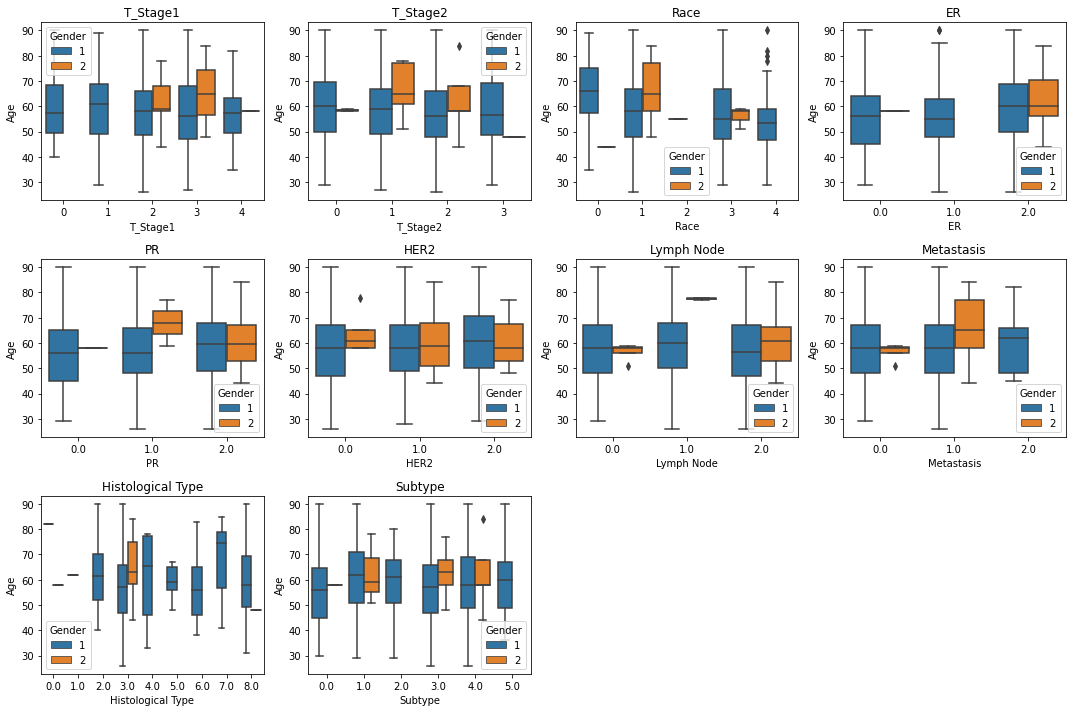

In [17]:
#Male vs. females
plt.figure(figsize=(15,10))
j=1
for i in ["T_Stage1","T_Stage2","Race","ER","PR","HER2",
          "Lymph Node","Metastasis","Histological Type","Subtype"] :
    plt.subplot(3,4,j)
    sn.boxplot(data = X_train, x = i, y = "Age", hue = "Gender")
    plt.title(i)
    j=j+1
    
plt.tight_layout()

.

There are no particular patterns or values for male patients with respect to females.

<AxesSubplot:xlabel='Age', ylabel='Count'>

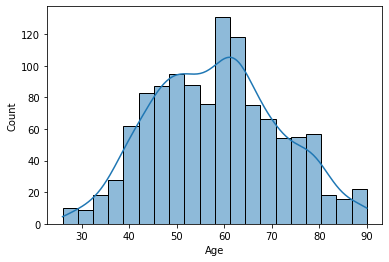

In [18]:
#Data distributions for "Age"
sn.histplot(x = X_train.Age, bins=20, kde=True)

.

The distribution might contain some outliers (at both tails). Let's check that using the *z-score*.

In [19]:
#Outliers with z-score larger than 3
print("The number of outliers in 'Age' is: {}".format(sum(abs((X_train.Age-X_train.Age.mean())/(X_train.Age.std()))>=3)))

The number of outliers in 'Age' is: 0


.

No outliers. Let's take a look at the target variable *Survival Status*.

In [20]:
#Target variable
100*y_train.value_counts()/len(y_train)

alive       84.160959
deceased    15.839041
Name: Survival Status, dtype: float64

.

It is unbalanced and that must be kept into account later. 

In the training session, a weighted classification will be performed: each model will be set to give more importance to the less frequent class.

In [21]:
#Convert strings to numbers for the target variable
y_train.replace(["alive","deceased"],[1,0],inplace=True)

.

Now, it is possible to scale all the numeric features using the MinMaxScaler function.

In [22]:
#Scaling features
Set_scaler = MinMaxScaler()            #It will be used later
Set_scaler.fit(X_train) 
X_train = pd.DataFrame(Set_scaler.transform(X_train),columns=X_train.columns)

.

Are there any non-significant features that can be dropped from the dataset?

Let's use the function *f_classif* to compute the p-value for each feature related to its "strength" to predict the target variable

In [23]:
#P-value
Pval = pd.DataFrame(f_classif(X_train,y_train)[1],index=X_train.columns, columns=["P-value"])

#Features with p-value larger than 0.05
Pval.iloc[np.where(Pval>0.05)[0]]

,P-value
Gender,0.418930
Race,0.468885
Lymph Node,0.351957
Metastasis,0.132738
Histological Type,0.054011


.

Those features seem not to be important for predicting the target variables therefore, they can be dropped from the dataset.

In [24]:
#Drop non-significant features
Pval_005 = Pval.iloc[np.where(Pval>0.05)[0]].index
X_train.drop(Pval_005,axis=1,inplace=True)

.

.

## **3. Data transformation function**

All the procedures and transformations above will be used on the Test set before applying the final model.

They will be included in the following function:

In [25]:
def Data_transformation(X,y) :
    #(1) Find the TSS code
    X["Tumour_info"] = X["Patient ID"].str.split("-",expand=True).iloc[:,1]
    X.drop(["Patient ID"],axis=1, inplace=True)
    
    #(2) Categorical data
    X["Definition"].replace(['primary solid tumor','solid tissue normal'],[1,2], inplace=True) 
    X["Gender"].replace(['female','male'],[1,2], inplace=True)
    X["Menopausal Status"].replace(['postmenopausal','perimenopausal','premenopausal','not available',
                                      'unknown','not evaluated','indeterminate'],[3,2,1,0,0,0,0], inplace=True)
    X["Race"].replace(['white','american indian or alaska native','black or african american','asian',
                       'not reported'],[1,2,3,4,0], inplace=True)
    X["ER"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
    X["PR"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
    X["HER2"].replace(['positive','negative','indeterminate','equivocal','not evaluated'],[2,1,0,0,0], inplace=True)
    X["Lymph Node"].replace(['present','absent'],[2,1], inplace=True)
    X["Metastasis"].replace(['present','absent'],[2,1], inplace=True)
    X["Histological Type"].replace(['infiltrating carcinoma nos','infiltrating lobular carcinoma','infiltrating ductal carcinoma',
                                      'medullary carcinoma','metaplastic carcinoma','mixed histology','mucinous carcinoma',
                                      'other','not available'],[1,2,3,4,5,6,7,8,0], inplace=True)
    X["Subtype"].replace(['Basal','Her2','LumA','LumB','Normal'],[1,2,3,4,5], inplace=True)
    X["Tumour_info"].replace(TSS,np.arange(1,len(TSS)+1), inplace=True)

    #Missing values
    X["Tumour Stage"].fillna("0",inplace=True)         
    X["Menopausal Status"].fillna(0,inplace=True)
    X["ER"].fillna(0,inplace=True)
    X["PR"].fillna(0,inplace=True)
    X["HER2"].fillna(0,inplace=True)
    X["Lymph Node"].fillna(0,inplace=True)
    X["Metastasis"].fillna(0,inplace=True)
    X["Histological Type"].fillna(0,inplace=True)
    X["Subtype"].fillna(0,inplace=True)

    #(3) Missing Age values
    X.Age.fillna(X_train_MEDIAN,inplace=True)

    #(4) Tumour Stage
    Num = X["Tumour Stage"].str.split("",expand=True)[1]
    Sta = X["Tumour Stage"].str.split("",expand=True)[2]
    Stage = pd.DataFrame(pd.concat([Num,Sta],axis=1))
    Stage.columns=["T_Stage1","T_Stage2"]
    i=0
    while i<len(Stage) :
        if Stage.iloc[i,0] == "X":
            Stage.iloc[i,0] = 0
        if Stage.iloc[i,1] == "a" :
            Stage.iloc[i,1] = 1
        if Stage.iloc[i,1] == "b" :
            Stage.iloc[i,1] = 2
        if Stage.iloc[i,1] == "c" :
            Stage.iloc[i,1] = 3
        if Stage.iloc[i,1]=="" :
            Stage.iloc[i,1] = 0
        i=i+1
    X = pd.concat([Stage,X],axis=1)
    X.drop(["Tumour Stage"],axis=1,inplace=True)
    X["T_Stage1"] = pd.to_numeric(X["T_Stage1"])
    X["T_Stage2"] = pd.to_numeric(X["T_Stage2"])
    
    #(5) Scaling features
    X = pd.DataFrame(Set_scaler.transform(X),columns=X.columns)
    
    #(6) Drop non-significant features
    X.drop(Pval_005,axis=1,inplace=True)
    
    #(7) Target variable
    y.replace(["alive","deceased"],[1,0],inplace=True)
    y = pd.Series(np.array(y))
    
    return X, y

.

.


## **4. Training: first models**

First, let's create a Training and a Test set: the first will be used for training the models while the second on to assess its goodness.

In [26]:
#Creation of a Training set and a Test set
#A stratified will be used to preserve the class proportions of the target variable
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state = 0)

for train_index, test_index in sss.split(np.array(X_train), np.array(y_train)):
    X_train_t, X_test_t = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_t, y_test_t = y_train.iloc[train_index], y_train.iloc[test_index]

.

Several models will be applied on the Training set to predict the variable "Survival Status".

A stratified k-fold cross-valiation method will be used to evaluate each model score (preserving the target class proportions).

The training and validation set will be splitted as 80-20% of the original dataset, respectively.

The cross-validation method will be repeated using different *random_state* values (i.e., different samplings).

In [27]:
#Iterative training with different models
Iterations = 10
Model_log2_acc,Model_tree2_acc,Model_ran2_acc,Model_xgb2_acc,Model_svm2_acc, Model_ada2_acc,Model_ext2_acc, Model_gau2_acc = 0,0,0,0,0,0,0,0
Model_log2_pre,Model_tree2_pre,Model_ran2_pre,Model_xgb2_pre,Model_svm2_pre, Model_ada2_pre,Model_ext2_pre, Model_gau2_pre = 0,0,0,0,0,0,0,0
Model_log2_rec,Model_tree2_rec,Model_ran2_rec,Model_xgb2_rec,Model_svm2_rec, Model_ada2_rec,Model_ext2_rec, Model_gau2_rec = 0,0,0,0,0,0,0,0
Model_log2_f1,Model_tree2_f1,Model_ran2_f1,Model_xgb2_f1,Model_svm2_f1, Model_ada2_f1,Model_ext2_f1, Model_gau2_f1 = 0,0,0,0,0,0,0,0
Model_log2_auc,Model_tree2_auc,Model_ran2_auc,Model_xgb2_auc,Model_svm2_auc, Model_ada2_auc,Model_ext2_auc, Model_gau2_auc = 0,0,0,0,0,0,0,0
for i in range(Iterations) :
    print(f'\r{100*(i)/(Iterations)} %', end='')       #Counter (%)
    #K-fold split
    CV = StratifiedKFold(n_splits = 5, random_state = i, shuffle = True)

    #Logistic regression
    Model_log = LogisticRegression(class_weight = "balanced")     #To give more importance to the less frequent class
    Model_log2_acc = Model_log2_acc + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_log2_pre = Model_log2_pre + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()      
    Model_log2_rec = Model_log2_rec + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()      
    Model_log2_f1 = Model_log2_f1 + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_log2_auc = Model_log2_auc + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()

    #Decision tree
    Model_tree = DecisionTreeClassifier(class_weight = "balanced", random_state = 0)
    Model_tree2_acc = Model_tree2_acc + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_tree2_pre = Model_tree2_pre + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()      
    Model_tree2_rec = Model_tree2_rec + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()     
    Model_tree2_f1 = Model_tree2_f1 + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_tree2_auc = Model_tree2_auc + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #Random forest
    Model_ran = RandomForestClassifier(class_weight = "balanced", random_state = 0)
    Model_ran2_acc = Model_ran2_acc + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_ran2_pre = Model_ran2_pre + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()      
    Model_ran2_rec = Model_ran2_rec + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()      
    Model_ran2_f1 = Model_ran2_f1 + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_ran2_auc = Model_ran2_auc + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #XGBoost
    Model_xgb = xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, 
                                  scale_pos_weight = (y_train_t==0).sum()/(y_train_t==1).sum(), seed=0)    #ratio neg/pos
    Model_xgb2_acc = Model_xgb2_acc + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_xgb2_pre = Model_xgb2_pre + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()      
    Model_xgb2_rec = Model_xgb2_rec + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()      
    Model_xgb2_f1 = Model_xgb2_f1 + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_xgb2_auc = Model_xgb2_auc + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #SVM
    Model_svm = svm.SVC(class_weight = "balanced")
    Model_svm2_acc = Model_svm2_acc + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_svm2_pre = Model_svm2_pre + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_svm2_rec = Model_svm2_rec + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()     
    Model_svm2_f1 = Model_svm2_f1 + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_svm2_auc = Model_svm2_auc + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #ADABoosting
    Model_ada = AdaBoostClassifier(random_state=0)
    Model_ada2_acc = Model_ada2_acc + cross_val_score(Model_ada, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_ada2_pre = Model_ada2_pre + cross_val_score(Model_ada, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_ada2_rec = Model_ada2_rec + cross_val_score(Model_ada, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()     
    Model_ada2_f1 = Model_ada2_f1 + cross_val_score(Model_ada, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_ada2_auc = Model_ada2_auc + cross_val_score(Model_ada, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #ExtraTrees
    Model_ext = ExtraTreesClassifier(class_weight = "balanced",random_state=0)
    Model_ext2_acc = Model_ext2_acc + cross_val_score(Model_ext, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_ext2_pre = Model_ext2_pre + cross_val_score(Model_ext, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_ext2_rec = Model_ext2_rec + cross_val_score(Model_ext, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()     
    Model_ext2_f1 = Model_ext2_f1 + cross_val_score(Model_ext, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_ext2_auc = Model_ext2_auc + cross_val_score(Model_ext, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #GaussianNB
    Model_gau = GaussianNB()
    Model_gau2_acc = Model_gau2_acc + cross_val_score(Model_gau, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_gau2_pre = Model_gau2_pre + cross_val_score(Model_gau, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_gau2_rec = Model_gau2_rec + cross_val_score(Model_gau, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()     
    Model_gau2_f1 = Model_gau2_f1 + cross_val_score(Model_gau, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_gau2_auc = Model_gau2_auc + cross_val_score(Model_gau, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()

        
#Final results
Data_res = {"Mean_accuracy" : [Model_log2_acc/Iterations,Model_tree2_acc/Iterations,Model_ran2_acc/Iterations,
                               Model_xgb2_acc/Iterations,Model_svm2_acc/Iterations,Model_ada2_acc/Iterations
                              ,Model_ext2_acc/Iterations,Model_gau2_acc/Iterations],
            "Mean_Precision" : [Model_log2_pre/Iterations,Model_tree2_pre/Iterations,Model_ran2_pre/Iterations,
                               Model_xgb2_pre/Iterations,Model_svm2_pre/Iterations,Model_ada2_pre/Iterations
                              ,Model_ext2_pre/Iterations,Model_gau2_pre/Iterations],
            "Mean_Recall" : [Model_log2_rec/Iterations,Model_tree2_rec/Iterations,Model_ran2_rec/Iterations,
                               Model_xgb2_rec/Iterations,Model_svm2_rec/Iterations,Model_ada2_rec/Iterations
                              ,Model_ext2_rec/Iterations,Model_gau2_rec/Iterations],
            "Mean_F1_score" : [Model_log2_f1/Iterations,Model_tree2_f1/Iterations,Model_ran2_f1/Iterations,
                               Model_xgb2_f1/Iterations,Model_svm2_f1/Iterations,Model_ada2_f1/Iterations
                              ,Model_ext2_f1/Iterations,Model_gau2_f1/Iterations],
            "Mean_AUC_score" : [Model_log2_auc/Iterations,Model_tree2_auc/Iterations,Model_ran2_auc/Iterations,
                               Model_xgb2_auc/Iterations,Model_svm2_auc/Iterations,Model_ada2_auc/Iterations
                              ,Model_ext2_auc/Iterations,Model_gau2_auc/Iterations]
            }

Results = pd.DataFrame(data = Data_res, index = ["Logistic", "DecisionTree","RandomForest","XGBoost","SVM","ADABoost","ExtraTrees","GaussianNB"])
Results.sort_values(by="Mean_accuracy",ascending=False)

90.0 %

,Mean_accuracy,Mean_Precision,Mean_Recall,Mean_F1_score,Mean_AUC_score
ADABoost,0.861786,0.884885,0.961080,0.921262,0.803941
RandomForest,0.861776,0.881438,0.965907,0.921606,0.787454
ExtraTrees,0.848073,0.880777,0.947973,0.912999,0.737095
XGBoost,0.826235,0.911130,0.879536,0.894756,0.811361
GaussianNB,0.821305,0.885169,0.905201,0.894923,0.737548
DecisionTree,0.808781,0.888183,0.884231,0.886004,0.646696
SVM,0.761677,0.913749,0.791603,0.847783,0.773974
Logistic,0.719916,0.909028,0.741730,0.816376,0.727919


.

.

## **5. Training: hyperparameters tuning**

The ensemble and boosting models seem to be the best ones (i.e., ADABoost, Random Forest, ExtraTrees, XGBoost).

Let's try to tune their hyperparameters. The scoring metric will be the *accuracy*.

In [28]:
#Hyperameters grid
Params_xgb = {"n_estimators":[100,200], "max_depth":[2,3,4], "reg_lambda":[2,3,5],"reg_alpha":[0.1,0.3],
              "eval_metric":["logloss"], "scale_pos_weight":[(y_train_t==0).sum()/(y_train_t==1).sum()], "seed": [0]}
Params_ran = {"n_estimators":[100,200], "max_depth":[2,3,4], "min_samples_split":[3,5],"min_samples_leaf":[3,5,8],
              "class_weight":["balanced"], "random_state": [0]}
Params_ada = {"n_estimators":[50,100,200], "learning_rate":[1.,2,5], "algorithm":["SAMME","SAMME.R"],"random_state": [0]}
Params_ext = {"n_estimators":[100,200], "max_depth":[2,3,4], "min_samples_split":[3,5],"min_samples_leaf":[3,5,8],
              "class_weight":["balanced"], "random_state": [0]}

#Grid search with a 5-fold cross-validation method
CV = KFold(n_splits=5, random_state = 0, shuffle=True)
Grid_xgb = GridSearchCV(Model_xgb, cv = CV, param_grid = Params_xgb, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_xgb2 = Grid_xgb.fit(X_train_t, y_train_t)
print("XGBoost model: done!")
Grid_ran = GridSearchCV(Model_ran, cv = CV, param_grid = Params_ran, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_ran2 = Grid_ran.fit(X_train_t, y_train_t)
print("RandomForest model: done!")
Grid_ada = GridSearchCV(Model_ada, cv = CV, param_grid = Params_ada, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_ada2 = Grid_ada.fit(X_train_t, y_train_t)
print("ADABoost model: done!")
Grid_ext = GridSearchCV(Model_ext, cv = CV, param_grid = Params_ext, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_ext2 = Grid_ext.fit(X_train_t, y_train_t)
print("ExtraTrees model: done!")

print("\n\nThe best XGBoost Classification model is: ",Grid_xgb2.best_params_)
print("The best Random Forest Classification model is: ",Grid_ran2.best_params_)
print("The best ADABoost Classification model is: ",Grid_ada2.best_params_)
print("The best ExtraTrees Classification model is: ",Grid_ext2.best_params_)
print("\nThe best XGBoost Classification Accuracy is: ",Grid_xgb2.best_score_)
print("The best Random Forest Classification Accuracy is: ",Grid_ran2.best_score_)
print("The best ADABoost Classification Accuracy is: ",Grid_ada2.best_score_)
print("The best ExtraTrees Classification Accuracy is: ",Grid_ext2.best_score_)

XGBoost model: done!
RandomForest model: done!
ADABoost model: done!
ExtraTrees model: done!


The best XGBoost Classification model is:  {'eval_metric': 'logloss', 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.3, 'reg_lambda': 2, 'scale_pos_weight': 0.18829516539440203, 'seed': 0}
The best Random Forest Classification model is:  {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200, 'random_state': 0}
The best ADABoost Classification model is:  {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 0}
The best ExtraTrees Classification model is:  {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200, 'random_state': 0}

The best XGBoost Classification Accuracy is:  0.8201541026967971
The best Random Forest Classification Accuracy is:  0.8169052958426771
The best ADABoost Classification Accuracy is:  0.8725835202116036
The best ExtraTrees 

.

The ADABoost model is the best one.

Models may have a good accuracy on the validation set but they may be overfitting the data.

Let's take a look at the training accuracy vs. validation accuracy plot: 

when a point is close to the unity line, it mean that the training and validation accuracies are similar.

On the contraty, when a point is far from the unity line, it means that the model is overfitting the data (i.e. high training accuracy and low validation accuracy).

A shaded blue region is defined as a "confidence interval against overfitting": points inside that region are related to models that do not overfit the data.

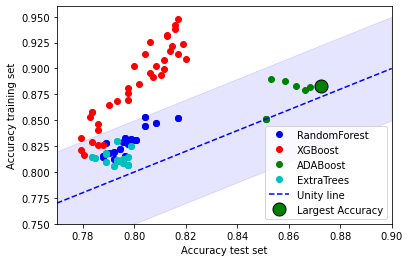

In [29]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(Grid_ran2.cv_results_["mean_test_score"]),pd.Series(Grid_ran2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(Grid_xgb2.cv_results_["mean_test_score"]),pd.Series(Grid_xgb2.cv_results_["mean_train_score"])],axis=1)
C = pd.concat([pd.Series(Grid_ada2.cv_results_["mean_test_score"]),pd.Series(Grid_ada2.cv_results_["mean_train_score"])],axis=1)
D = pd.concat([pd.Series(Grid_ext2.cv_results_["mean_test_score"]),pd.Series(Grid_ext2.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
C.columns=["Test","Train"]
D.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
C.sort_values("Test")
D.sort_values("Test")
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot(C.Test,C.Train,'og')
plt.plot(D.Test,D.Train,'oc')
plt.plot([0.77,0.90],[0.77,0.90],'--b')
plt.fill_between([0.77,0.90],[0.82,0.95],[0.72,0.85],color='blue',alpha=0.1, label="_nolegend_")
plt.plot(C.Test[np.argmax(C.Test)],C.Train[np.argmax(C.Test)],'go',markersize=13,mec="black")
#plt.plot(A.Test[np.argmax(A.Test)],A.Train[np.argmax(A.Test)],'bo',markersize=13,mec="black")
plt.ylim([0.75,0.96])
plt.xlim([0.77,0.90])
plt.xlabel("Accuracy test set")
plt.ylabel("Accuracy training set")
plt.legend(["RandomForest","XGBoost","ADABoost","ExtraTrees","Unity line","Largest Accuracy"], loc="lower right")

.

Almost all XGBoost models are overfitting the data. RandomForest and ExtraTrees models are similar (not drastically overfitting).

ADABoost model is the best one (lowest level of overfitting and highest accuracy).

Let's use this model to evaluate its performance on the Test set.

The Accuracy on the Training set is:  87.69% (AUC: 0.87)
The Accuracy on the Test set is:  85.04% (AUC: 0.77)



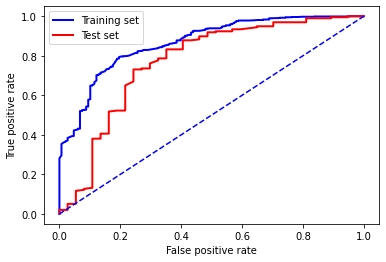

In [30]:
#Accuracy on training and test set
Model_ada = AdaBoostClassifier(**Grid_ada2.best_params_)
Model11 = Model_ada.fit(X_train_t,y_train_t)

Final_accuracy_tr = (Model11.predict(X_train_t) == y_train_t).sum()/len(y_train_t)
Final_accuracy_te = (Model11.predict(X_test_t) == y_test_t).sum()/len(y_test_t)
print("The Accuracy on the Training set is:  {:.2f}% (AUC: {:.2f})".format(100*Final_accuracy_tr, roc_auc_score(y_train_t,Model11.predict_proba(X_train_t)[:,1])))
print("The Accuracy on the Test set is:  {:.2f}% (AUC: {:.2f})\n".format(100*Final_accuracy_te,roc_auc_score(y_test_t,Model11.predict_proba(X_test_t)[:,1])))

#ROC curve
fpr1, tpr1, thresholds1 = roc_curve(y_train_t,Model11.predict_proba(X_train_t)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test_t,Model11.predict_proba(X_test_t)[:,1])
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set","Test set"])

In [31]:
#Precision, Recall, F1-score, Confusion matrix
Conf_matrix = confusion_matrix(y_test_t, Model11.predict(X_test_t))
print("Precision: {:.2f}".format(precision_score(y_test_t, Model11.predict(X_test_t))))
print("Recall: {:.2f}".format(recall_score(y_test_t, Model11.predict(X_test_t))))
print("F1-score: {:.2f}\n".format(f1_score(y_test_t, Model11.predict(X_test_t))))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Dead","Predicted_Alive"], index=["Actual_Dead","Actual_Alive"])

Precision: 0.86
Recall: 0.97
F1-score: 0.92



,Predicted_Dead,Predicted_Alive
Actual_Dead,7,30
Actual_Alive,5,192


.

Let's combine two models, i.e. ADABoost, RandomForest, and ExtraTrees (which do not overfit the data).

In [32]:
Mod1 = RandomForestClassifier(**Grid_ran2.best_params_)
Mod2 = AdaBoostClassifier(**Grid_ada2.best_params_)
Mod3 = ExtraTreesClassifier(**Grid_ext2.best_params_)

ModelA = VotingClassifier(estimators=[('rf', Mod1), ('ada', Mod2), ('ext', Mod3)], voting="soft")
ModelA.fit(X_train_t, y_train_t)

Final_accuracy_trA = (ModelA.predict(X_train_t) == y_train_t).sum()/len(y_train_t)
Final_accuracy_teA = (ModelA.predict(X_test_t) == y_test_t).sum()/len(y_test_t)

print("The Accuracy on the Training set (soft voting) is:  {:.2f}% (AUC: {:.2f})".format(100*Final_accuracy_trA, roc_auc_score(y_train_t,ModelA.predict_proba(X_train_t)[:,1])))
print("The Accuracy on the Test set (soft voting) is:  {:.2f}% (AUC: {:.2f})\n".format(100*Final_accuracy_teA,roc_auc_score(y_test_t,ModelA.predict_proba(X_test_t)[:,1])))

The Accuracy on the Training set (soft voting) is:  84.69% (AUC: 0.87)
The Accuracy on the Test set (soft voting) is:  80.77% (AUC: 0.76)



.

The accuracies (on both Training and Test set) are lower.

Let's use only the ADABoost classifier.

.

.

## **6. Model finalization**

Now, the model can be *finalized* by using the entire dataset (Training + Test)

In [33]:
#Final training on the whole dataset
Model_ada = AdaBoostClassifier(**Grid_ada2.best_params_)
Best_model = Model_ada.fit(X_train, y_train)

#Final accuracy on the whole dataset
Final_accuracy = (Best_model.predict(X_train) == y_train).sum()/len(y_train)
print("The final Accuracy on the whole Training set is:  {:.2f}% (AUC: {:.2f})\n".format(100*Final_accuracy,roc_auc_score(y_train,Model11.predict_proba(X_train)[:,1])))

The final Accuracy on the whole Training set is:  87.50% (AUC: 0.85)



In [34]:
#Precision, Recall, F1-score, Confusion matrix
Conf_matrix = confusion_matrix(y_train, Best_model.predict(X_train))
print("Precision: {:.2f}".format(precision_score(y_train, Best_model.predict(X_train))))
print("Recall: {:.2f}".format(recall_score(y_train, Best_model.predict(X_train))))
print("F1-score: {:.2f}\n".format(f1_score(y_train, Best_model.predict(X_train))))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Dead","Predicted_Alive"], index=["Actual_Dead","Actual_Alive"])

Precision: 0.88
Recall: 0.98
F1-score: 0.93



,Predicted_Dead,Predicted_Alive
Actual_Dead,58,127
Actual_Alive,19,964


.

.


## **7. Test on unseen data**

Now the final model can be tested on the *unseen data* chosen randomly at the beginning of this notebook.

First, data must be transformed before the model application.

In [35]:
#Data transformation
X_test, y_test = Data_transformation(X_test,y_test)

In [36]:
#Accuracy on the Test set
Final_accuracy_test = (Best_model.predict(X_test) == y_test).sum()/len(y_test)
print("The accuracy on the unseen Test set is:  {:.2f}%\n".format(100*Final_accuracy_test))

#Confusion matrix
Conf_matrix = confusion_matrix(y_test, Best_model.predict(X_test))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Dead","Predicted_Alive"], index=["Actual_Dead","Actual_Alive"])

The accuracy on the unseen Test set is:  75.68%



,Predicted_Dead,Predicted_Alive
Actual_Dead,3,8
Actual_Alive,1,25


.

Let's use all the data to finalize the model further (Training + Unseen data)

In [37]:
#Data transformation
X, y = Data_transformation(Data.drop(["Survival Status"],axis=1), Data["Survival Status"])

#Final training on the whole dataset
Model_ada = AdaBoostClassifier(**Grid_ada2.best_params_)
Best_model = Model_ada.fit(X, y)

#Final accuracy on the whole dataset
Final_accuracy = (Best_model.predict(X) == y).sum()/len(y)
print("The final Accuracy on the whole Training set is:  {:.2f}% (AUC: {:.2f})\n".format(100*Final_accuracy,roc_auc_score(y,Model11.predict_proba(X)[:,1])))

#Precision, Recall, F1-score, Confusion matrix
Conf_matrix = confusion_matrix(y, Best_model.predict(X))
print("Precision: {:.2f}".format(precision_score(y, Best_model.predict(X))))
print("Recall: {:.2f}".format(recall_score(y, Best_model.predict(X))))
print("F1-score: {:.2f}\n".format(f1_score(y, Best_model.predict(X))))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Dead","Predicted_Alive"], index=["Actual_Dead","Actual_Alive"])

The final Accuracy on the whole Training set is:  87.22% (AUC: 0.85)

Precision: 0.88
Recall: 0.98
F1-score: 0.93



,Predicted_Dead,Predicted_Alive
Actual_Dead,59,137
Actual_Alive,17,992


.


### **Final thoughts**

The final accuracies (i.e., training, test, unseen, total) are very similar to each other meaning that the model does not overfit the data drastically.

Clearly, a larger dataset may lead to more precise model even though the final results obtained in this notebook are still fairly good.